In [1]:
!pip install shap
!pip install alibi
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

     |████████████████████████████████| 327kB 1.6MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456471 sha256=e877c9db9c9e1c5c39fe8085f2f0e73b3b52e20e44953f99f231b316f964ec91
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap
     |████████████████████████████████| 225kB 2.0MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
     |████████████████████████████████| 28.0MB 146kB/s 
     |████████████████████████████████| 204kB 39.4MB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=0418f244668610de95f0b558490861d41d8e7ec6659d0ad21d37ffe88219e4b3
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built spacy-lookups-data


In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=5)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [3]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.547101
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.370056
[200]	test-logloss:0.325397
[300]	test-logloss:0.308336
[400]	test-logloss:0.300134
[500]	test-logloss:0.295712
[600]	test-logloss:0.293019
[700]	test-logloss:0.291632
[800]	test-logloss:0.290451
[900]	test-logloss:0.289912
[1000]	test-logloss:0.28942
Stopping. Best iteration:
[988]	test-logloss:0.289402



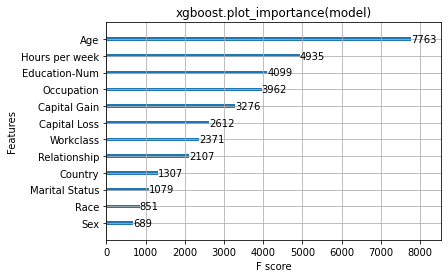

In [4]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

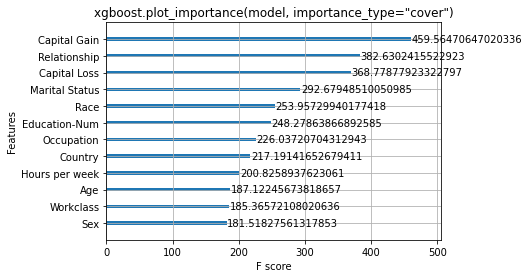

In [5]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

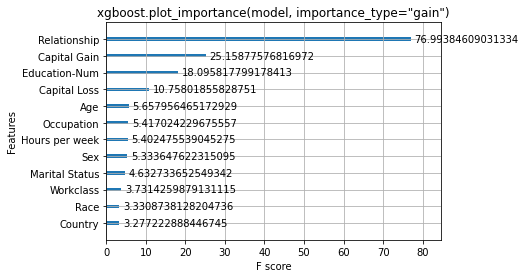

In [6]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

In [7]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])


In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])


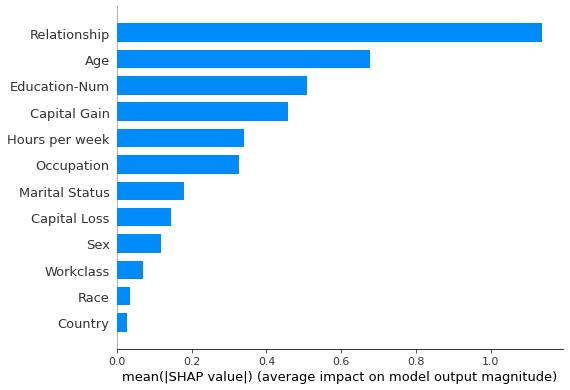

In [10]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

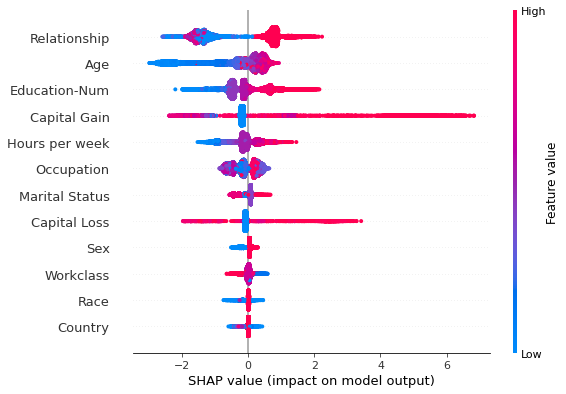

In [11]:
shap.summary_plot(shap_values, X)

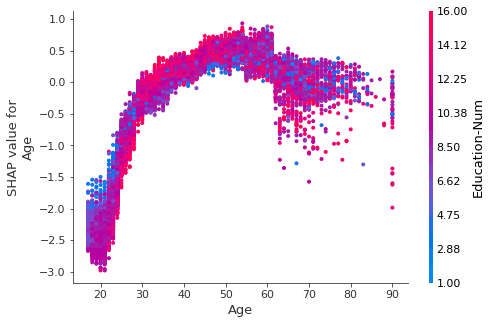

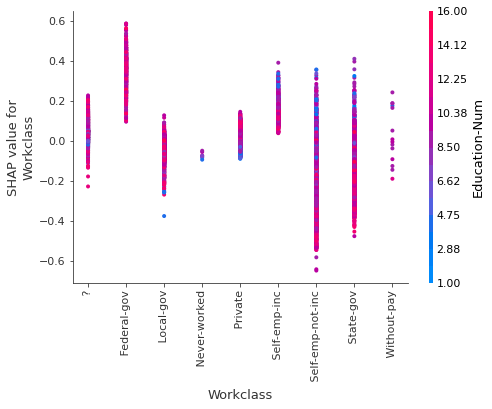

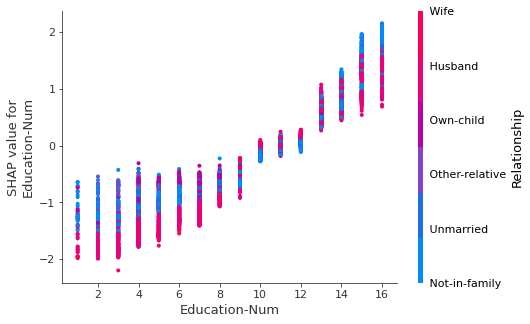

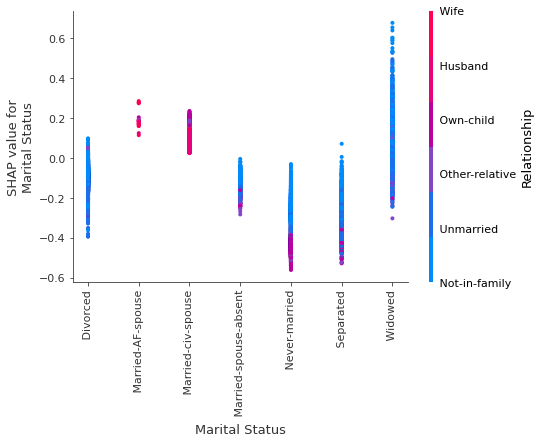

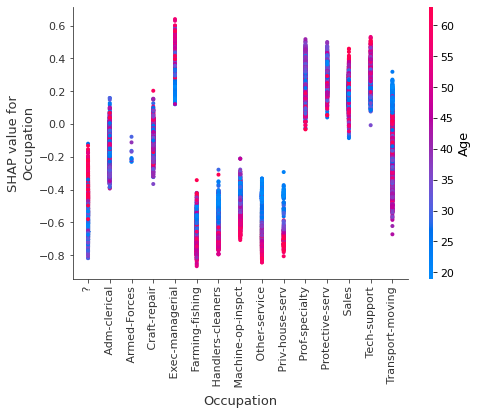

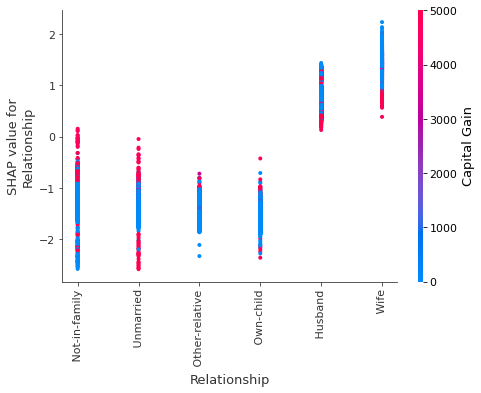

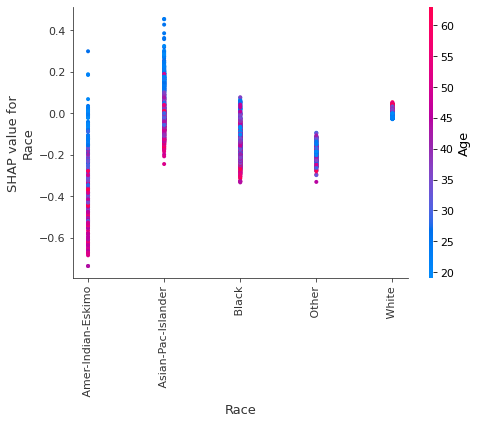

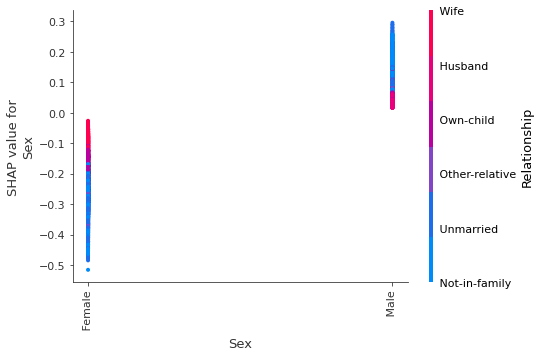

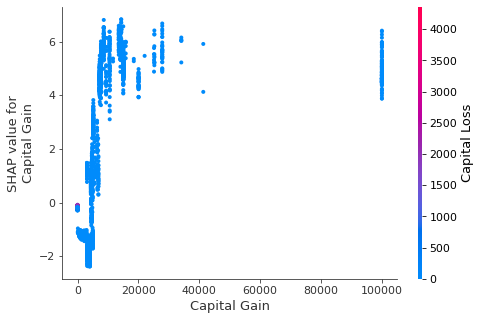

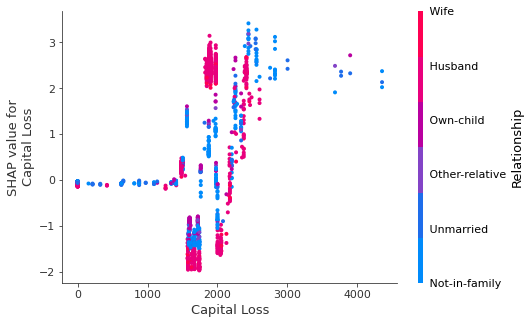

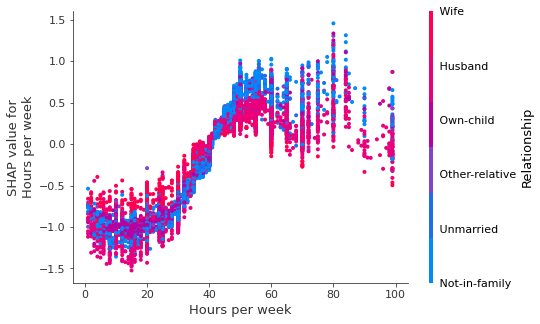

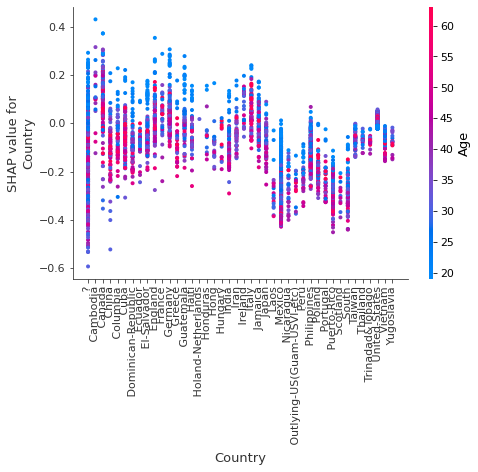

In [12]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

In [14]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

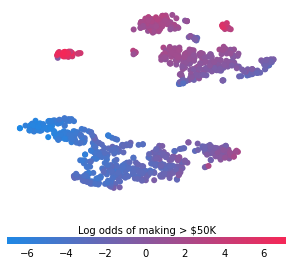

In [15]:
f = pl.figure(figsize=(5,5))
pl.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = pl.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
pl.gca().axis("off")
pl.show()


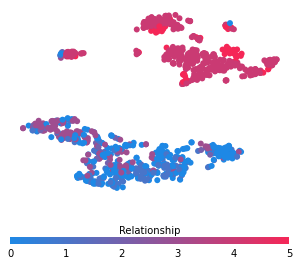

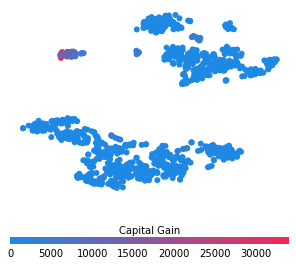

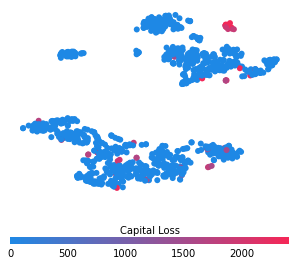

In [16]:
for feature in ["Relationship", "Capital Gain", "Capital Loss"]:
    f = pl.figure(figsize=(5,5))
    pl.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=X[feature].values[:1000].astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = pl.colorbar(label=feature, aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    pl.gca().axis("off")
    pl.show()

In [17]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model_ind = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.541531
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.362059
[200]	test-logloss:0.334247
[300]	test-logloss:0.32492
[400]	test-logloss:0.319644
[500]	test-logloss:0.315474
[600]	test-logloss:0.312758
[700]	test-logloss:0.310578
[800]	test-logloss:0.308983
[900]	test-logloss:0.308115
[1000]	test-logloss:0.307152
[1100]	test-logloss:0.306192
[1200]	test-logloss:0.305421
Stopping. Best iteration:
[1183]	test-logloss:0.305331



In [18]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


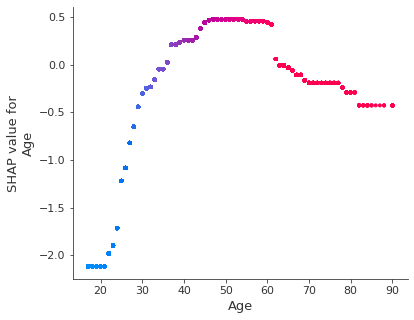

invalid value encountered in true_divide
invalid value encountered in true_divide


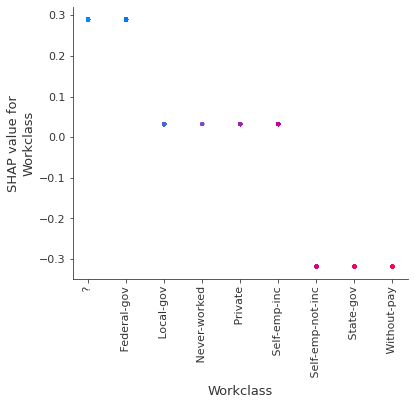

invalid value encountered in true_divide
invalid value encountered in true_divide


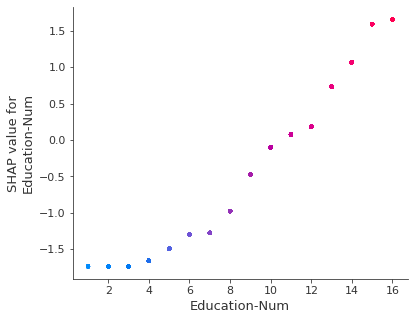

invalid value encountered in true_divide
invalid value encountered in true_divide


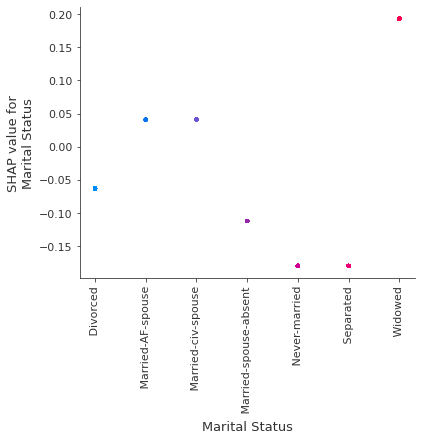

invalid value encountered in true_divide
invalid value encountered in true_divide


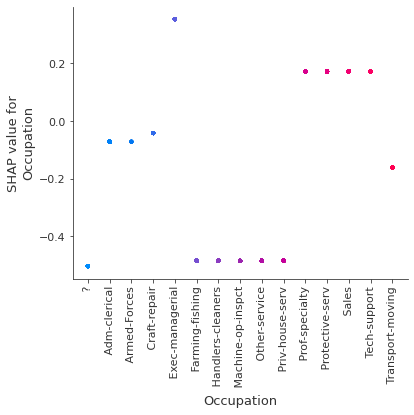

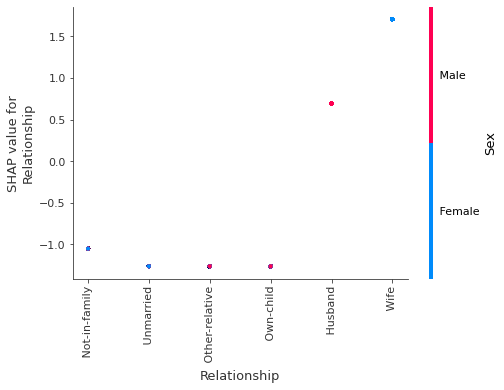

invalid value encountered in true_divide
invalid value encountered in true_divide


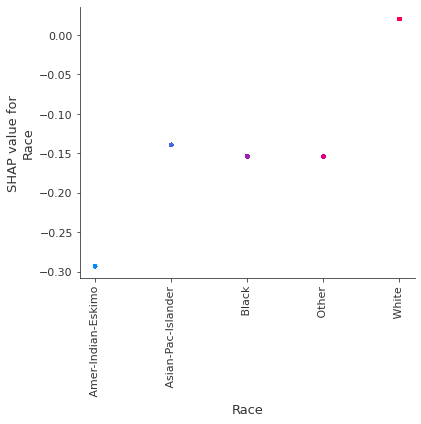

invalid value encountered in true_divide
invalid value encountered in true_divide


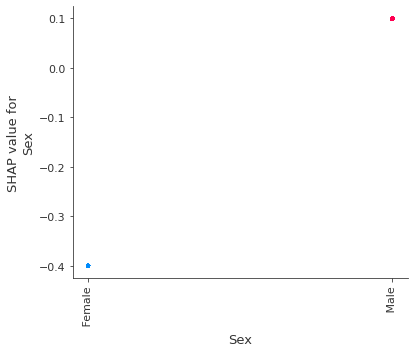

invalid value encountered in true_divide
invalid value encountered in true_divide


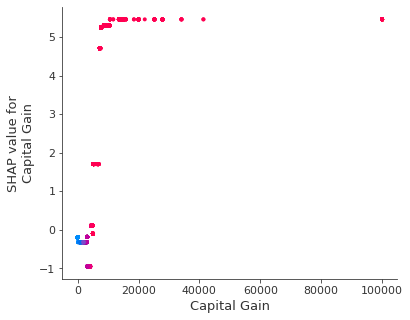

invalid value encountered in true_divide
invalid value encountered in true_divide


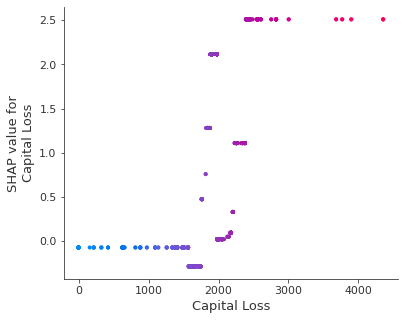

invalid value encountered in true_divide
invalid value encountered in true_divide


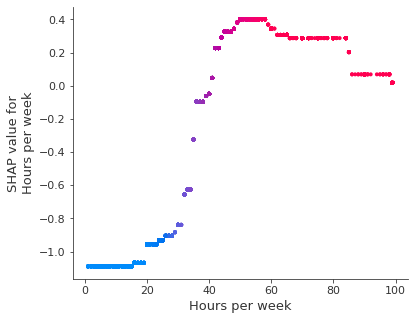

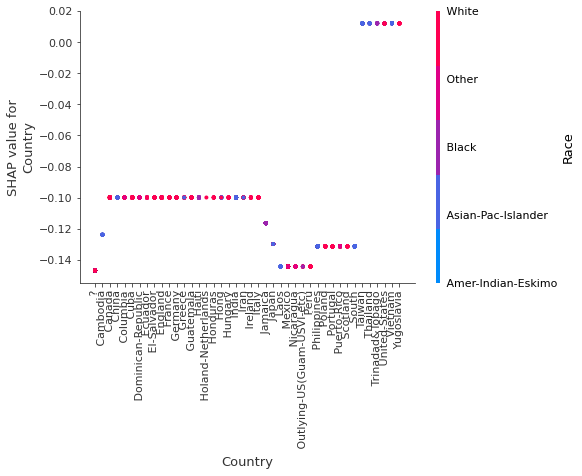

In [19]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind, X, display_features=X_display)